## Data Preparation 

In [3]:
using JuliaDB
using VegaDatasets
using Plots
using Statistics
using Flux
using DataFrames

In [4]:
cars = dataset("cars") |> table

Table with 406 rows, 9 columns:
Columns:
#  colname           type
────────────────────────────────────────────
1  Name              String
2  Miles_per_Gallon  Union{Missing, Float64}
3  Cylinders         Int64
4  Displacement      Float64
5  Horsepower        Union{Missing, Int64}
6  Weight_in_lbs     Int64
7  Acceleration      Float64
8  Year              String
9  Origin            String

In [6]:
ML.schema(cars)

Dict{Symbol,Any} with 9 entries:
  :Cylinders        => Continous(μ=5.475369458128076, σ=1.7121596315485288)
  :Horsepower       => Maybe{Continuous}(Continous(μ=105.08250000000002, σ=38.7…
  :Displacement     => Continous(μ=194.77955665024618, σ=104.92245837948875)
  :Weight_in_lbs    => Continous(μ=2979.4137931034484, σ=847.0043282393509)
  :Miles_per_Gallon => Maybe{Continuous}(Continous(μ=23.514572864321607, σ=7.81…
  :Year             => nothing
  :Acceleration     => Continous(μ=15.51970443349754, σ=2.803358816342545)
  :Origin           => nothing
  :Name             => nothing

Let's override the `Cylinders` and `Origin` schema by converting them to `Categorical`.

In [7]:
cars_schema = ML.schema(cars,hints = Dict(
        :Cylinders => ML.Categorical,
        :Origin => ML.Categorical
    )
)

Dict{Symbol,Any} with 9 entries:
  :Cylinders        => Categorical([8, 4, 6, 3, 5])
  :Horsepower       => Maybe{Continuous}(Continous(μ=105.08250000000002, σ=38.7…
  :Displacement     => Continous(μ=194.77955665024618, σ=104.92245837948875)
  :Weight_in_lbs    => Continous(μ=2979.4137931034484, σ=847.0043282393509)
  :Miles_per_Gallon => Maybe{Continuous}(Continous(μ=23.514572864321607, σ=7.81…
  :Year             => nothing
  :Acceleration     => Continous(μ=15.51970443349754, σ=2.803358816342545)
  :Origin           => Categorical(["USA", "Europe", "Japan"])
  :Name             => nothing

The rest with `nothing` in their entries will be ignored during modeling.

### Prepare data for regression example.

Let's split the data and use `Weight_in_lbs` as the output for regression.

In [9]:
input_schema, output_schema = ML.splitschema(cars_schema,:Weight_in_lbs);

In [10]:
input_schema

Dict{Symbol,Any} with 8 entries:
  :Cylinders        => Categorical([8, 4, 6, 3, 5])
  :Horsepower       => Maybe{Continuous}(Continous(μ=105.08250000000002, σ=38.7…
  :Displacement     => Continous(μ=194.77955665024618, σ=104.92245837948875)
  :Origin           => Categorical(["USA", "Europe", "Japan"])
  :Miles_per_Gallon => Maybe{Continuous}(Continous(μ=23.514572864321607, σ=7.81…
  :Year             => nothing
  :Acceleration     => Continous(μ=15.51970443349754, σ=2.803358816342545)
  :Name             => nothing

In [11]:
output_schema

Dict{Symbol,Any} with 1 entry:
  :Weight_in_lbs => Continous(μ=2979.4137931034484, σ=847.0043282393509)

Let's extract the input features based on the input schema. Categorical data will be represented in one-hot encoding scheme. Julia also transposes the observations into columns for faster processing because it's a column-major language. 

In [13]:
input = ML.featuremat(input_schema,cars)

14×406 LinearAlgebra.Adjoint{Float32,Array{Float32,2}}:
  1.0        1.0       1.0       …   0.0        0.0        0.0     
  0.0        0.0       0.0           1.0        1.0        1.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0       …   0.0        0.0        0.0     
  0.642721   1.54551   1.1586       -0.543801  -0.672771  -0.595389
  1.06956    1.47938   1.1744       -0.56975   -0.712713  -0.722243
  1.0        1.0       1.0           1.0        1.0        1.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0       …   0.0        0.0        0.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
 -0.705551  -1.08938  -0.705551      1.08565    0.573879   0.957708
 -1.25553   -1.43389  -1.61225      -1.39822    1.09879    1

In [14]:
output = ML.featuremat(output_schema,cars)

1×406 LinearAlgebra.Adjoint{Float32,Array{Float32,2}}:
 0.619343  0.842482  0.53906  0.535518  …  -0.80804  -0.418432  -0.306272

Let's create a function to split the data into training and testing.

In [17]:
using Random
function partitionTrainTest(input,output, at = 0.8)
    @assert size(input,2) == size(output,2)
    n = size(input,2)
    idx = shuffle(1:n)
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    return (input[:,train_idx], output[:,train_idx], input[:,test_idx],output[:,test_idx])
end

partitionTrainTest (generic function with 2 methods)

In [18]:
train_input,train_output,test_input,test_output = partitionTrainTest(input,output,0.7)

(Float32[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 1.0; … ; -1.4732083 0.7018217 … 0.4203472 0.19004992; -1.4338887 0.3496861 … -0.93448776 0.70640105], Float32[2.3324394 -0.8977685 … -0.32988474 -0.71358997], Float32[0.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 0.5738787 -0.4240762 … 0.062106974 -0.3856933; -0.007028866 0.09998562 … 0.7420725 0.49237207], Float32[-0.8446401 -0.017017378 … 0.038472302 0.5260731])

## Flux Regression

In Flux, you setup the model by chaining layers where each layer is composed of data dimension and the output function. There are different types of layers such as `Dense`, `LSTM`, `Conv`, `Dropout`, `BatchNorm`, etc.

In [23]:
function fluxregression(data,lr=0.01,iterations=1000,hidden=10,checkpoint=0.1)
    model = Chain(
        Dense(ML.width(input_schema),hidden,relu),
        Dense(hidden,ML.width(output_schema))
    )
     
    #loss(x,y) = Flux.crossentropy(model(x),y)
    loss(x, y) = Flux.mse(model(x), y)

    opt = ADAM(lr) 
    evalcb = Flux.throttle(() -> @show(loss(first(data)...)), checkpoint);
    
    for i = 1:iterations
      Flux.train!(loss, params(model),data, opt, cb = evalcb)
    end
    return model
end

fluxregression (generic function with 5 methods)

In neural network training, learning rate and the size of max-iteration are crucial to avoid overfitting or underfitting. Too small learning rate with small max-iteration size lead to premature convergence or underfitting. Too small learning rate with very large max-iteration size may result to overfitting. Cross-validation can help but requires splitting the data into three sets (training, testing, and validation).

loss(first(data)...) = 2.0754004f0 (tracked)
loss(first(data)...) = 0.14384368f0 (tracked)
loss(first(data)...) = 0.06578082f0 (tracked)
loss(first(data)...) = 0.053928643f0 (tracked)
loss(first(data)...) = 0.048934363f0 (tracked)
loss(first(data)...) = 0.0467017f0 (tracked)
loss(first(data)...) = 0.04456601f0 (tracked)
loss(first(data)...) = 0.042708457f0 (tracked)
loss(first(data)...) = 0.041112296f0 (tracked)
loss(first(data)...) = 0.039300893f0 (tracked)
loss(first(data)...) = 0.03770077f0 (tracked)
loss(first(data)...) = 0.036783185f0 (tracked)
loss(first(data)...) = 0.035944592f0 (tracked)
loss(first(data)...) = 0.035467412f0 (tracked)
loss(first(data)...) = 0.033881005f0 (tracked)
loss(first(data)...) = 0.033367984f0 (tracked)
rmse=0.30942255


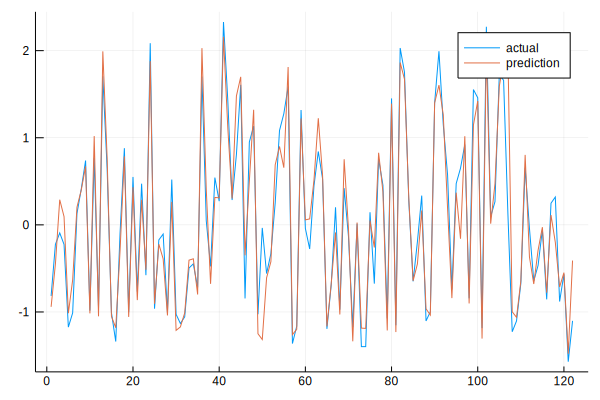

In [75]:
# data preparation
input_schema, output_schema = ML.splitschema(cars_schema,:Weight_in_lbs);
input = ML.featuremat(input_schema,cars)
output = ML.featuremat(output_schema,cars)
train_input,train_output,test_input,test_output = partitionTrainTest(input,output,0.7);
data = [(train_input, train_output)] #|> gpu;

model = fluxregression(data,0.001,5000)
yhat=model(test_input)
y=test_output
rmse = sqrt((y .- yhat.data).^2 |> mean ) 
println("rmse=",rmse)
plot([y' yhat.data'],lab=["actual","prediction"])

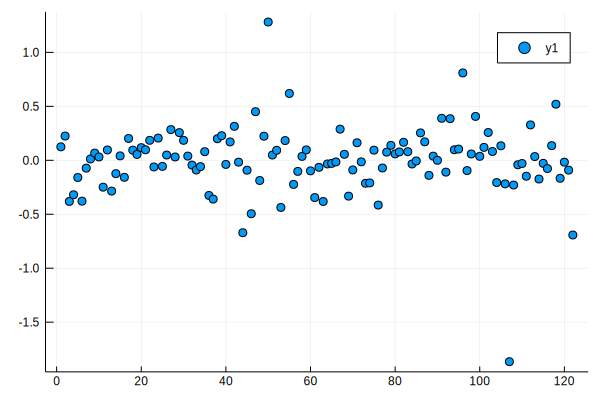

In [76]:
scatter([y' .- yhat.data'])

## Flux Classification

In [123]:
function fluxclassification(data,lr=0.01,iterations=1000,hidden=10,checkpoint=0.1)
    model = Chain(
        Dense(ML.width(input_schema),hidden,relu),
        Dense(hidden,ML.width(output_schema)),
        softmax
    )
     
    loss(x,y) = Flux.mse(model(x),y)

    opt = ADAM(lr) 
    evalcb = Flux.throttle(() -> @show(loss(first(data)...)), checkpoint);
    
    for i = 1:iterations
      Flux.train!(loss, params(model),data, opt, cb = evalcb)
    end
    return model
end
perf(x, y) = mean(Flux.onecold(x) .== Flux.onecold(y))*100

perf (generic function with 1 method)

In [124]:
input_schema, output_schema = ML.splitschema(cars_schema,:Cylinders);
input = ML.featuremat(input_schema,cars)
output = ML.featuremat(output_schema,cars)
train_input,train_output,test_input,test_output = partitionTrainTest(input,output,0.7)
data = [(train_input, train_output)] 

model = fluxclassification(data,0.01,1000)
yhat=model(test_input)
perf(yhat,test_output)

loss(first(data)...) = 0.1815878f0 (tracked)
loss(first(data)...) = 0.009972285f0 (tracked)
loss(first(data)...) = 0.0068006404f0 (tracked)
loss(first(data)...) = 0.0052436483f0 (tracked)
loss(first(data)...) = 0.0040837997f0 (tracked)


93.44262295081968

In [85]:
using RCall

In [86]:
pred = Flux.onecold(yhat.data)
gt = Flux.onecold(test_output);

In [87]:
R"table($pred,$gt)"

RObject{IntSxp}
   
     1  2  3  5
  1 31  0  0  0
  2  0 64  1  3
  3  2  1 20  0


In [112]:
cars |> DataFrame |> x-> x.Cylinders |> x->R"table($x)"

RObject{IntSxp}

  3   4   5   6   8 
  4 207   3  84 108 


## Flux MNIST

### MLP (multi-layer perceptron)

In [113]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated
# using CuArrays

# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) |> gpu

m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) |> gpu

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))*100

fdataset = repeated((X, Y), 50)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()

Flux.train!(loss, params(m), fdataset, opt, cb = throttle(evalcb, 5))

accuracy(X, Y)

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) |> gpu
tY = onehotbatch(MNIST.labels(:test), 0:9) |> gpu

accuracy(tX, tY)

loss(X, Y) = 2.327312f0 (tracked)
loss(X, Y) = 1.7624899f0 (tracked)
loss(X, Y) = 1.2707424f0 (tracked)
loss(X, Y) = 0.90222764f0 (tracked)
loss(X, Y) = 0.69394493f0 (tracked)


85.3

### Convolution layers

In [ ]:
using Flux, Metalhead, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Metalhead: trainimgs
using Images: channelview
using Statistics: mean
using Base.Iterators: partition

# VGG16 and VGG19 models

vgg16() = Chain(
  Conv((3, 3), 3 => 64, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(64),
  Conv((3, 3), 64 => 64, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(64),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 64 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  Conv((3, 3), 128 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  x -> maxpool(x, (2,2)),
  Conv((3, 3), 128 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 256 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  x -> maxpool(x, (2, 2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(512, 4096, relu),
  Dropout(0.5),
  Dense(4096, 4096, relu),
  Dropout(0.5),
  Dense(4096, 10),
  softmax) |> gpu


# Function to convert the RGB image to Float64 Arrays

getarray(X) = Float32.(permutedims(channelview(X), (2, 3, 1)))

# Fetching the train and validation data and getting them into proper shape

X = trainimgs(CIFAR10)
imgs = [getarray(X[i].img) for i in 1:50000]
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)
train = gpu.([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, 100)])
valset = collect(49001:50000)
valX = cat(imgs[valset]..., dims = 4) |> gpu
valY = labels[:, valset] |> gpu

# Defining the loss and accuracy functions

m = vgg16()

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

# Defining the callback and the optimizer

evalcb = throttle(() -> @show(accuracy(valX, valY)), 10)

opt = ADAM()

# Starting to train models

Flux.train!(loss, params(m), train, opt, cb = evalcb)

# Fetch the test data from Metalhead and get it into proper shape.
# CIFAR-10 does not specify a validation set so valimgs fetch the testdata instead of testimgs

test = valimgs(CIFAR10)

testimgs = [getarray(test[i].img) for i in 1:10000]
testY = onehotbatch([test[i].ground_truth.class for i in 1:10000], 1:10) |> gpu
testX = cat(testimgs..., dims = 4) |> gpu

# Print the final accuracy

@show(accuracy(testX, testY))